# Image Classification With Neural Networks

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm

import matplotlib.pyplot as plt
import numpy as np

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [6]:
dataset_path = r'/Users/krummelha/Downloads/STA380-master/data/EuroSAT_RGB'


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
trainset = torchvision.datasets.ImageFolder(root = dataset_path, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 2)

In [12]:
train_size = int(0.8 * len(trainset))
test_size = len(trainset) - train_size

In [14]:
train_dataset, test_dataset = torch.utils.data.random_split(trainset, [train_size, test_size])

In [16]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 2)

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, 3, 1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Fully connected layers with Dropout
        self.fc1 = nn.Linear(256, 128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        
        x = self.dropout1(x)
        x = self.fc1(x)
        x = F.relu(x)
        
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x


# Instantiate the network
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=Tru

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification (6 classes in this case)
optimizer = optim.SGD(net.parameters(), lr=0.01)


In [22]:
num_epochs = 15

for epoch in range(num_epochs):
    running_loss = 0.0
    testiter = iter(testloader)  # Reinitialize the test iterator for each epoch

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 20 == 0:
            with torch.no_grad():
                try:
                    test_images, test_labels = next(testiter)
                    test_images, test_labels = test_images.to(device), test_labels.to(device)

                    test_outputs = net(test_images[:8])
                    _, predicted = torch.max(test_outputs, 1)
                    print('Predicted:', ' '.join('%d' % predicted[j] for j in range(8)))

                except StopIteration:
                    # If the test iterator is exhausted, reinitialize it
                    testiter = iter(testloader)
                    print("Test data iterator exhausted; reinitializing...")

    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')

Predicted: 8 0 9 9 7 3 9 7
Predicted: 4 4 4 8 7 9 9 4
Predicted: 4 1 4 4 4 9 9 4
Predicted: 4 4 1 4 4 9 9 4
Predicted: 1 0 4 9 1 4 1 4
Predicted: 1 4 7 1 4 4 1 4
Predicted: 4 1 0 1 4 4 1 8
Predicted: 0 1 7 1 7 4 7 7
Predicted: 1 1 0 0 4 7 4 9
Predicted: 7 1 0 4 7 7 1 0
Predicted: 1 9 4 7 1 0 7 9
Predicted: 0 7 1 8 4 9 0 6
Predicted: 1 9 7 0 8 0 7 7
Predicted: 4 8 0 0 7 9 4 1
Predicted: 4 6 7 1 7 2 0 9
Predicted: 8 6 6 4 9 1 0 4
Predicted: 9 7 6 5 7 5 7 0
Epoch 1, Loss: 1.7325282202669854
Predicted: 4 2 0 4 3 1 4 9
Predicted: 7 7 7 1 0 1 9 6
Predicted: 7 1 7 6 7 9 8 0
Predicted: 0 3 1 3 7 0 1 7
Predicted: 5 0 2 8 9 4 8 2
Predicted: 2 8 6 1 4 4 9 7
Predicted: 4 5 2 8 2 7 9 8
Predicted: 9 1 5 1 8 6 2 4
Predicted: 1 9 0 0 7 2 7 8
Predicted: 3 1 2 0 7 3 1 0
Predicted: 8 9 4 4 2 0 7 1
Predicted: 6 6 9 5 4 1 8 4
Predicted: 1 8 2 0 8 6 8 7
Predicted: 4 2 0 2 7 5 4 5
Predicted: 6 2 4 1 3 5 0 9
Predicted: 8 7 2 4 9 1 5 4
Predicted: 9 7 6 9 3 0 3 2
Epoch 2, Loss: 1.0531686043598243
Predicted: 4 2

In [24]:
all_labels = []
all_predictions = []

# Set the model to evaluation mode
net.eval()

with torch.no_grad():  # Disable gradient computation for evaluation
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Get predictions from the model
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Print the confusion matrix
print(conf_matrix)

[[571   2   9   1   0   9   8   0   6   9]
 [  0 569  24   0   0   1   0   0   0   8]
 [ 15   3 563   0   0   5  12   0   0   9]
 [ 24   0  46 361  31   6  12   0  30   0]
 [  1   0  32   0 447   0   0   0   0   0]
 [  6  18  63   0   0 306   4   0   9   0]
 [ 32   0  96   0   3   1 340   0   1   0]
 [  0   0 184   0  37   0   0 396   0   0]
 [ 19   3  40   5   5   5   4   0 398   9]
 [  3   7   0   0   0   1   0   0   0 591]]


## Overall Test Set Accuracy

In [31]:
# Calculate accuracy
correct_predictions = sum(np.array(all_labels) == np.array(all_predictions))
total_predictions = len(all_labels)
accuracy = correct_predictions / total_predictions

print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 84.11%


## Confusion Matrix

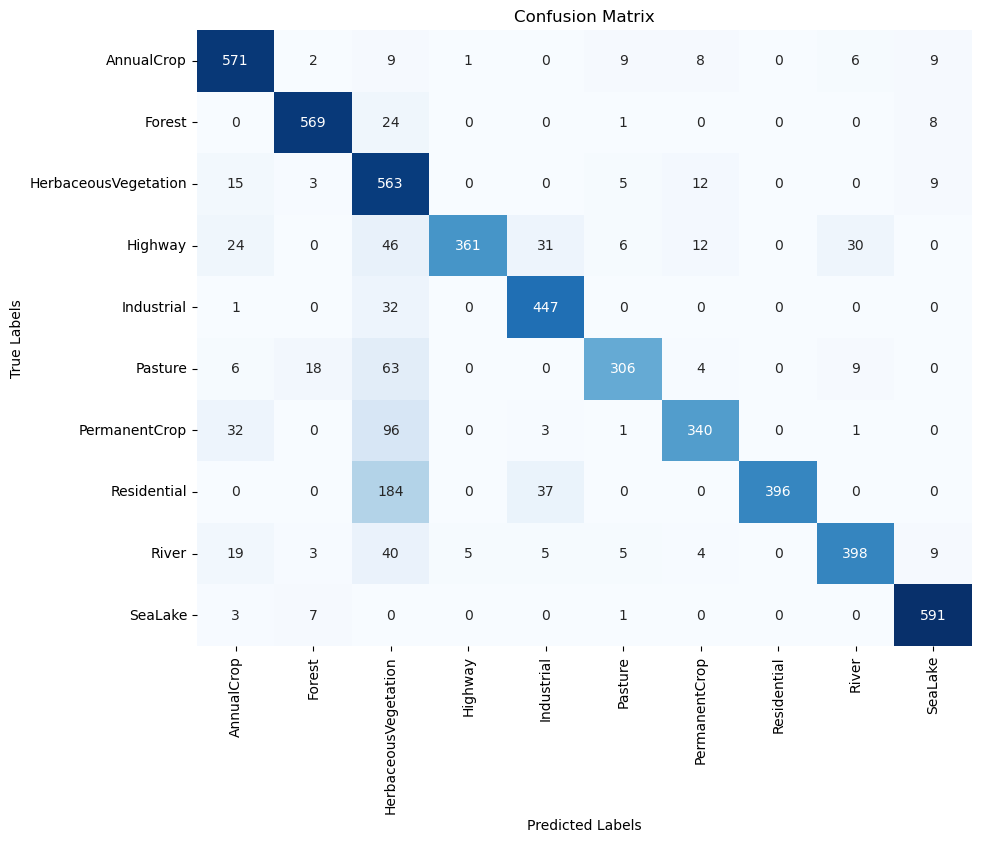

In [49]:
# Code From Chat GPT To make a pretty Confusion Matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = trainset.classes

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=class_names, yticklabels=class_names)

# Add labels to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Show the plot
plt.show()

## Examples from Test Set with Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


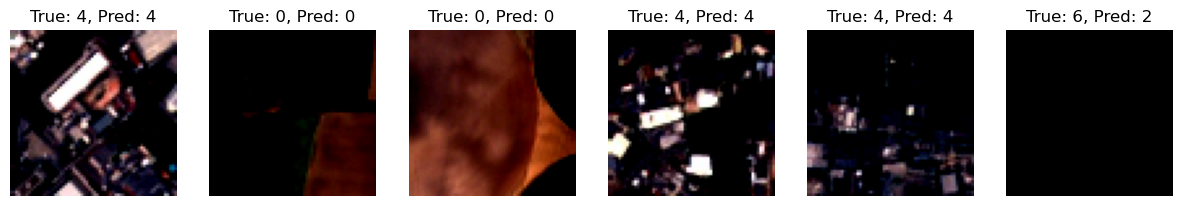

In [43]:
# Function to display images with their predicted labels
def show_images(images, labels, predictions, num_images=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.title(f"True: {labels[i]}, Pred: {predictions[i]}")
        plt.axis('off')
    plt.show()

# Get a batch of images from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Get predictions from the model
outputs = net(images)
_, predictions = torch.max(outputs, 1)

# Show the images with true and predicted labels
show_images(images.cpu(), labels.cpu().numpy(), predictions.cpu().numpy(), num_images=6)

## Overall Summary of Results

Overall, this model did a great job of predicting on the test set. However, there are some commonly occuring errors. The model overpredicted Herbaceous Vegetation across the board, more specifically wrongly predicting 184 residential areas, 96 Permanent Crop areas, and 63 Pasture areas as Herbaceous Vegetation. Moreover, the model also made many of its errors classifying Residential areas as Industrial areas and Permanent Crop areas as Annual Crop Areas. While these errors occurred within the model, the accuracy rate of 84.11% demonstrates that the model successfully predicted the accurate class in most cases. 